# Predicting which New York Times blog articles will be the most popular

##### This is from a past Kaggle <a href='https://www.kaggle.com/c/15-071x-the-analytics-edge-competition-spring-2015'>competition</a> from the course, <a href='https://www.edx.org/course/analytics-edge-mitx-15-071x'>The Analytics Edge,</a> that I completed a few months ago in R. This time I am going to use Python and the <a href='http://scikit-learn.org/stable/index.html'>scikit-learn</a> machine learning library.

Newspapers and online news aggregators like Google News need to understand which news articles will be the most popular, so that they can prioritize the order in which stories appear. In this competition, you will predict the popularity of a set of New York Times blog articles from the time period September 2014-December 2014.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.4, rc={'line.linewidth': 2.5})
%matplotlib inline

## Load, inspect and clean the data

In [4]:
# Lets inspect the data set
! head -n 2 NYTimesBlogTrain.csv

"NewsDesk","SectionName","SubsectionName","Headline","Snippet","Abstract","WordCount","PubDate","Popular","UniqueID"
"Business","Crosswords/Games","","More School Daze","A puzzle from Ethan Cooper that reminds me that a bill is due.","A puzzle from Ethan Cooper that reminds me that a bill is due.",508,"2014-09-01 22:00:09",1,1


In [5]:
dataset = pd.read_csv("NYTimesBlogTrain.csv")
dataset.head(2).transpose()

,0,1
NewsDesk,Business,Culture
SectionName,Crosswords/Games,Arts
SubsectionName,NaN,NaN
Headline,More School Daze,New 96-Page Murakami Work Coming in December
Snippet,A puzzle from Ethan Cooper that reminds me tha...,The Strange Library will arrive just three and...
Abstract,A puzzle from Ethan Cooper that reminds me tha...,The Strange Library will arrive just three and...
WordCount,508,285
PubDate,2014-09-01 22:00:09,2014-09-01 21:14:07
Popular,1,0
UniqueID,1,2


In [6]:
# I can see some NaN values from the table above, let's see if there are more
dataset.isnull().sum()

NewsDesk          1846
SectionName       2300
SubsectionName    4826
Headline             0
Snippet              9
Abstract             9
WordCount            0
PubDate              0
Popular              0
UniqueID             0
dtype: int64

In [7]:
# Imputing missing values
dataset.SectionName = dataset.SectionName.fillna("UNSPECIFIED")
dataset.SubsectionName = dataset.SubsectionName.fillna("UNSPECIFIED")
dataset.NewsDesk = dataset.NewsDesk.fillna("UNSPECIFIED")
dataset.Snippet = dataset.Snippet.fillna("")
dataset.Abstract = dataset.Snippet.fillna("")
dataset.isnull().sum()

NewsDesk          0
SectionName       0
SubsectionName    0
Headline          0
Snippet           0
Abstract          0
WordCount         0
PubDate           0
Popular           0
UniqueID          0
dtype: int64

## Data Exploration

In [8]:
print dataset.shape
dataset.Popular.value_counts()

(6532, 10)


0    5439
1    1093
dtype: int64

About 20% of the articles are popular

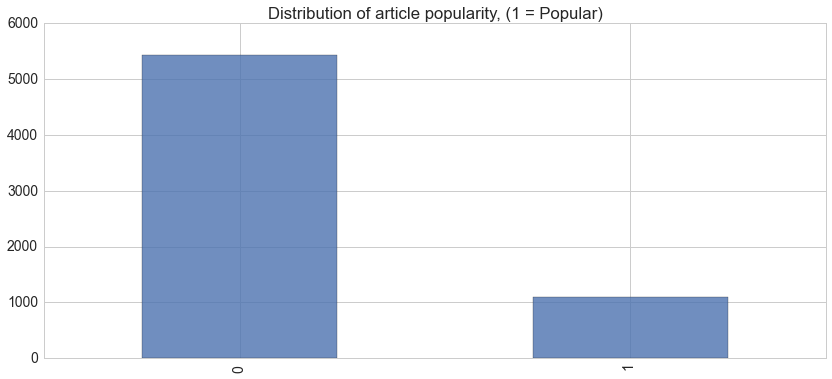

In [9]:
plt.figure(figsize=(14, 6))
dataset.Popular.value_counts().plot(kind='bar', alpha=.8)
plt.title("Distribution of article popularity, (1 = Popular)");  

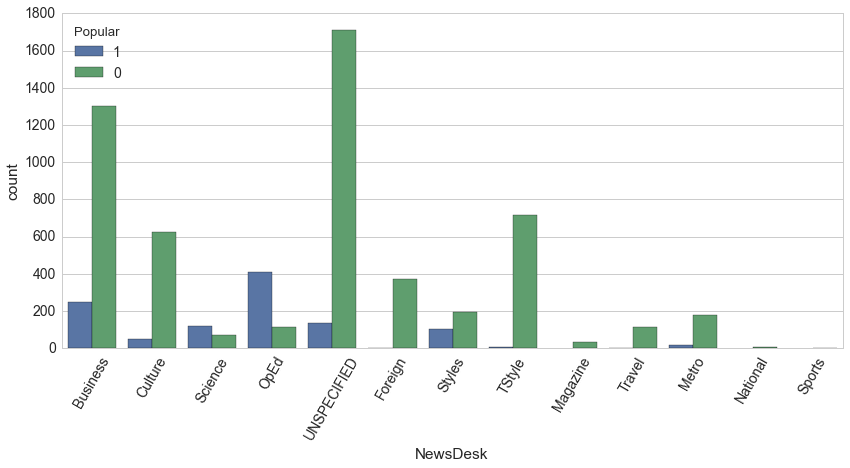

In [10]:
plt.figure(figsize=(14, 6))
sns.countplot(x="NewsDesk", hue="Popular", data=dataset);
plt.xticks(rotation=60);

It looks like the "OpEd" news desk section is very popular

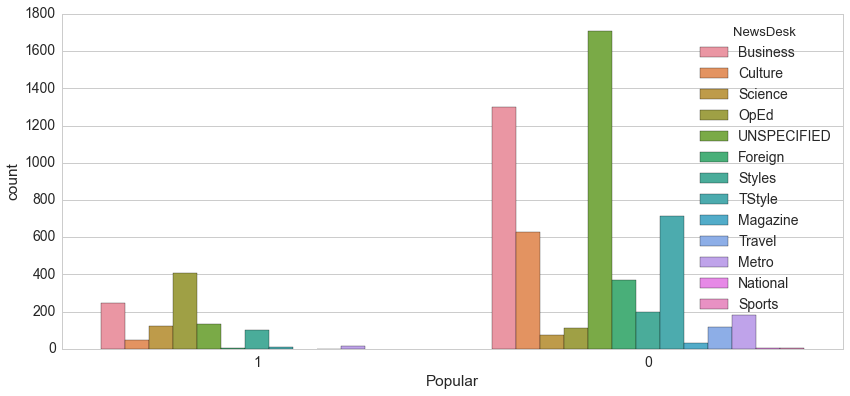

In [11]:
plt.figure(figsize=(14, 6))
sns.countplot(x="Popular", hue="NewsDesk", data=dataset);

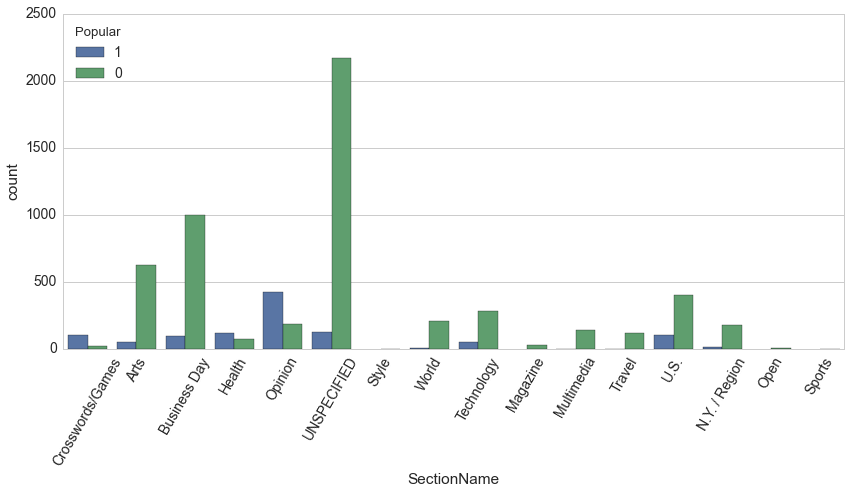

In [12]:
plt.figure(figsize=(14, 6))
sns.countplot(x="SectionName", hue="Popular", data=dataset)
plt.xticks(rotation=60);

Here the "Opinion Section" is the most popular

## Feature Engineering
I am curious to find out if the day of the week and time of the day affect the popularity of the articles.

In [13]:
from datetime import datetime
dataset['weekday'] = dataset.apply(lambda row: datetime.strptime(row['PubDate'],
                            '%Y-%m-%d %H:%M:%S').weekday(), axis=1)
dataset['hour'] = dataset.apply(lambda row: datetime.strptime(row['PubDate'], 
                            '%Y-%m-%d %H:%M:%S').hour, axis=1)

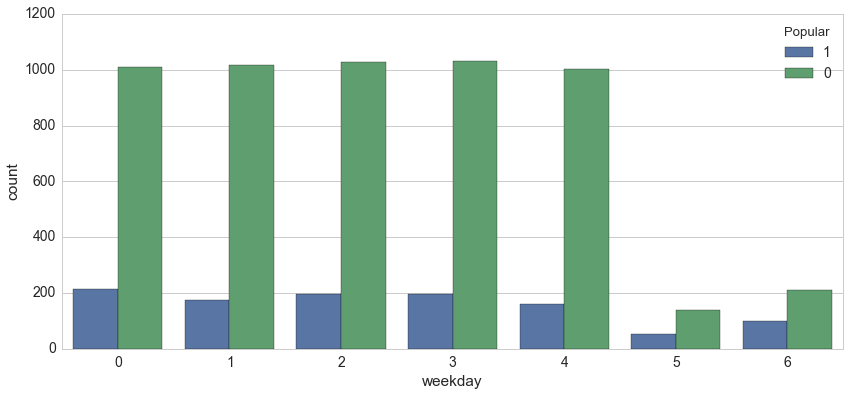

In [14]:
plt.figure(figsize=(14, 6));
sns.countplot(x="weekday", hue="Popular", data=dataset);

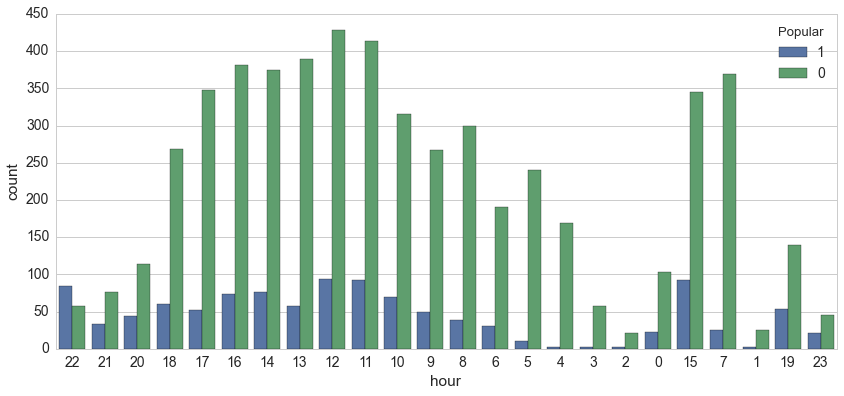

In [15]:
plt.figure(figsize=(14, 6));
sns.countplot(x="hour", hue="Popular", data=dataset);

## Predicting article popularity
There are several algorithms we can use try. I am going to try Naive Bayes and Logistic Regression.

### TF-IDF Vectorizing

In [16]:
# Combining all text fields for corpus creation
dataset["all_text"] = dataset.Headline + " " + dataset.Snippet + " "+ dataset.Abstract
#dataset.drop(dataset.columns[[4,5,9]], axis=1, inplace=True)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [18]:
corpus = dataset.all_text
stopset = set(stopwords.words("english"))
corpus.head()

0    More School Daze A puzzle from Ethan Cooper th...
1    New 96-Page Murakami Work Coming in December T...
2    Public Pension Funds Stay Mum on Corporate Exp...
3    Boot Camp for Bankers As they struggle to find...
4    Of Little Help to Older Knees Middle-aged and ...
Name: all_text, dtype: object

In [19]:
vectorizer = TfidfVectorizer(stop_words=stopset, analyzer='word',
                             lowercase=True, max_features=20, use_idf=True, ngram_range=(1,3), max_df=0.3)
word_matrix = vectorizer.fit_transform(corpus)

In [20]:
word_matrix[0]

<1x20 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [21]:
print word_matrix[0]

### Naive Bayes

In [37]:
X = word_matrix
y = dataset.Popular
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
print X_train.shape, X_test.shape

(4899, 20) (1633, 20)


In [38]:
multinom = MultinomialNB()
multinom.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
train_score = multinom.score(X_train, y_train)
test_score = multinom.score(X_test, y_test)
print train_score, test_score

0.833027148398 0.831598285364


### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(word_matrix, dataset.Popular, random_state=99)
model = LogisticRegression()
X = word_matrix
y = dataset.Popular
model = model.fit(X_train, y_train)
predicted = model.predict(X_test)
print metrics.accuracy_score(y_test, predicted)

0.831598285364


### Including engineered features

In [41]:
# Lets include weekday and hour
X = pd.concat([dataset[['weekday', 'hour']], pd.DataFrame(word_matrix.toarray())], axis=1)
X.head()

,weekday,hour,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0,22,0,0,0,0,0,0,0,0.00000,...,0,0,0,0,0,0,0,0,0.000000,0
1,0,21,0,0,0,0,0,0,0,0.27503,...,0,0,0,0,0,0,0,0,0.961436,0
2,0,21,0,0,0,0,0,0,0,0.00000,...,0,0,0,0,0,0,0,0,0.000000,0
3,0,20,0,0,0,0,0,0,0,1.00000,...,0,0,0,0,0,0,0,0,0.000000,0
4,0,18,0,0,0,0,0,0,0,1.00000,...,0,0,0,0,0,0,0,0,0.000000,0


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, dataset.Popular, random_state=99)
model = LogisticRegression()
model = model.fit(X_train, y_train)
predicted = model.predict(X_test)
print metrics.accuracy_score(y_test, predicted)

0.831598285364


In [43]:
# Including other factors
# Encoding textual data into numerical format understood by scikit-learn
from sklearn import preprocessing
label_encoder_news_desk = preprocessing.LabelEncoder()
label_encoder_section_name = preprocessing.LabelEncoder()
label_encoder_sub_section_name = preprocessing.LabelEncoder()
news_desk = label_encoder_news_desk.fit_transform(dataset.NewsDesk)
section_name = label_encoder_section_name.fit_transform(dataset.SectionName)
subsection = label_encoder_sub_section_name.fit_transform(dataset.SubsectionName)

In [44]:
X = pd.concat([pd.DataFrame(news_desk, columns=["NewsDesk"]), 
           pd.DataFrame(section_name, columns=["SectionName"]), 
           pd.DataFrame(subsection, columns=["Subsection"]),
          dataset[['weekday', 'hour']], pd.DataFrame(word_matrix.toarray())], axis=1)
X.head()

,NewsDesk,SectionName,Subsection,weekday,hour,0,1,2,3,4,...,10,11,12,13,14,15,16,17,18,19
0,0,2,8,0,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0
1,1,0,8,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.961436,0
2,0,1,1,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0
3,0,1,1,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0
4,7,3,8,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, dataset.Popular, random_state=99)
model = LogisticRegression()
model = model.fit(X_train, y_train)
predicted = model.predict(X_test)
print metrics.accuracy_score(y_test, predicted)

0.835884874464


## Observations
* The best model was logistic regression that included the engineered features
* There are many other ways that can be used to improve the model, tweaking TF-IDF Vectorizing, for example
* I would like to use cross validation techniques as well

